# Proper Orthogonal Decomposition (POD) Analysis
## Von Karman Vortex Street - Real CFD Data

This notebook demonstrates **Proper Orthogonal Decomposition (POD)** applied to **real CFD simulation data**.

## What is POD?
POD (also known as PCA in statistics or KL decomposition) is a powerful technique that:
- Extracts the **most energetic coherent structures** from complex data
- Provides **optimal basis functions** for data representation
- Enables **dimensionality reduction** while preserving key physics

## Dataset
- **Source**: Brunton & Kutz, *Data-Driven Science and Engineering*
- **Physics**: Von Karman vortex street (flow past cylinder, Re ~ 100)
- **Data**: Real CFD vorticity field snapshots

---

## 1. Setup and Imports

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.fft import fft, fftfreq
import urllib.request
import os
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
plt.style.use('default')


print('Libraries loaded successfully!')

Libraries loaded successfully!


## 2. Load Real Vortex Data

Loading real CFD simulation data of **Von Karman vortex street** - flow past a cylinder.

In [16]:
# Download data if not present
data_file = 'vortex_data.mat'
if not os.path.exists(data_file):
    print('Downloading vortex data from Brunton & Kutz repository...')
    url = 'https://github.com/dynamicslab/databook_python/raw/master/DATA/VORTALL.mat'
    urllib.request.urlretrieve(url, data_file)
    print('Downloaded!')

# Load data
mat_data = loadmat(data_file)
VORTALL = mat_data['VORTALL']

print(f'Raw data shape: {VORTALL.shape}')
print(f'Data range: [{VORTALL.min():.3f}, {VORTALL.max():.3f}]')

# Data structure: VORTALL is (n_spatial, n_snapshots)
# Grid is 199 x 449 = 89351 spatial points, 151 time snapshots
m, n = VORTALL.shape
ny, nx = 199, 449  # ny = transverse (y), nx = streamwise (x)

print(f'\nSpatial points: {m} ({ny} x {nx} = {ny*nx})')
print(f'Time snapshots: {n}')

# For POD: X should be (n_snapshots, n_features)
X = VORTALL.T  # Now (151, 89351)
n_snapshots = X.shape[0]
time = np.arange(n_snapshots)  # Time indices

print(f'\nPOD matrix X shape: {X.shape} (snapshots x spatial)')

Raw data shape: (89351, 151)
Data range: [-18.253, 18.252]

Spatial points: 89351 (199 x 449 = 89351)
Time snapshots: 151

POD matrix X shape: (151, 89351) (snapshots x spatial)


### 2.1 Visualize Vorticity Snapshots

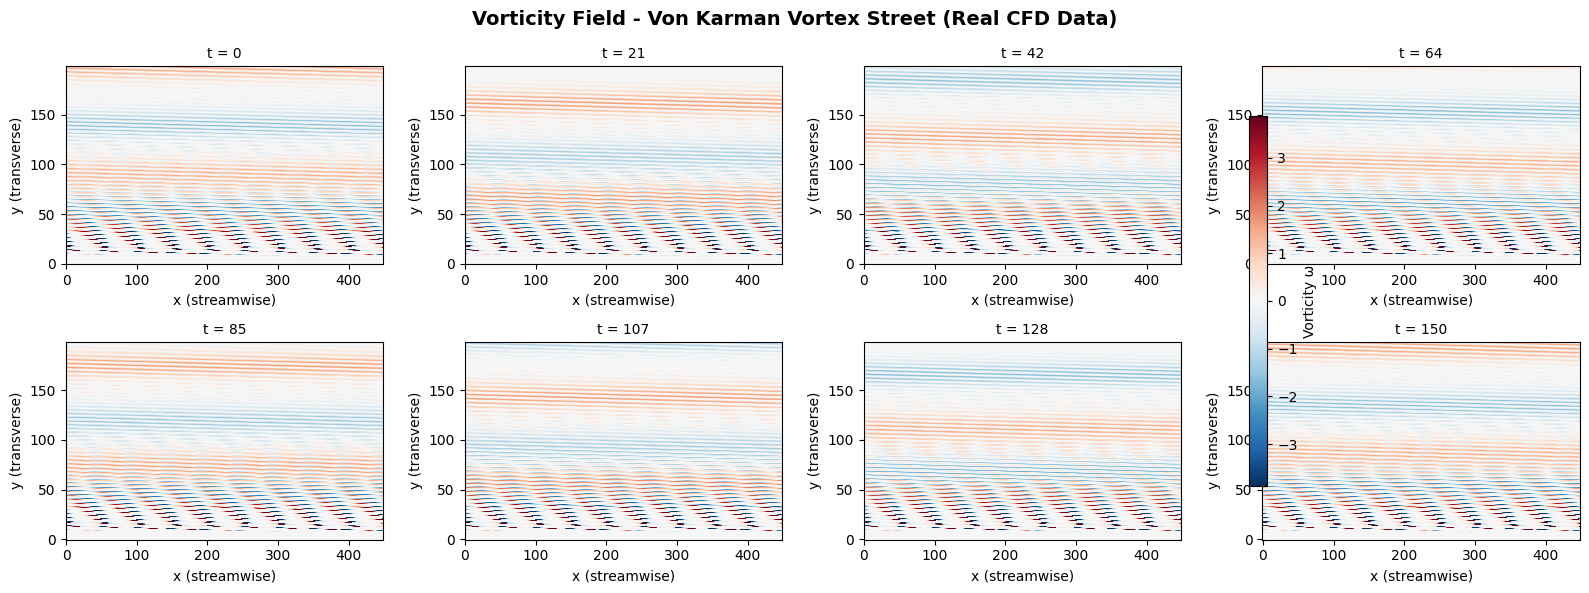

Red = positive vorticity (counter-clockwise)
Blue = negative vorticity (clockwise)
Alternating vortices = Von Karman vortex street


In [17]:
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
fig.suptitle('Vorticity Field - Von Karman Vortex Street (Real CFD Data)', fontsize=14, fontweight='bold')

indices = np.linspace(0, n_snapshots-1, 8, dtype=int)
vmax = np.percentile(np.abs(VORTALL), 99)

for i, ax in enumerate(axes.flat):
    idx = indices[i]
    # Reshape column-major (Fortran order) and transpose for correct orientation
    field = VORTALL[:, idx].reshape((ny, nx), order='C')

    im = ax.imshow(field, cmap='RdBu_r', aspect='auto',
                   vmin=-vmax, vmax=vmax, origin='lower')
    ax.set_title(f't = {idx}', fontsize=10)
    ax.set_xlabel('x (streamwise)')
    ax.set_ylabel('y (transverse)')

plt.colorbar(im, ax=axes, label='Vorticity ω', shrink=0.8)
plt.tight_layout()
plt.show()

print('Red = positive vorticity (counter-clockwise)')
print('Blue = negative vorticity (clockwise)')
print('Alternating vortices = Von Karman vortex street')

## 3. POD Implementation

In [18]:
class POD:
    def __init__(self):
        self.modes = None
        self.singular_values = None
        self.temporal_coeffs = None
        self.mean = None
        self.energy_per_mode = None
        self.cumulative_energy = None
        
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        U, sigma, Vt = np.linalg.svd(X_centered, full_matrices=False)
        
        self.singular_values = sigma
        self.modes = Vt.T  # Spatial modes (columns)
        self.temporal_coeffs = U * sigma  # Temporal coefficients

        total_energy = np.sum(sigma**2)
        self.energy_per_mode = (sigma**2) / total_energy
        self.cumulative_energy = np.cumsum(self.energy_per_mode)
        return self
    
    def reconstruct(self, n_modes):
        return self.temporal_coeffs[:, :n_modes] @ self.modes[:, :n_modes].T + self.mean

print('POD class defined!')

POD class defined!


## 4. Apply POD to Vortex Data

In [19]:
pod = POD()
pod.fit(X)

n_modes_total = len(pod.singular_values)

print(f'{"="*60}')
print('POD DECOMPOSITION RESULTS')
print(f'{"="*60}')
print(f'Total modes extracted: {n_modes_total}')
print(f'\nTop 10 POD Modes Energy Content:')
print('-' * 40)
for i in range(10):
    bar = '█' * int(pod.energy_per_mode[i] * 100)
    print(f'  Mode {i+1:2d}: {pod.energy_per_mode[i]*100:6.2f}% {bar}')

print(f'\nCumulative Energy:')
print('-' * 40)
for n in [1, 3, 5, 10, 20, 50]:
    if n <= n_modes_total:
        print(f'  {n:3d} modes: {pod.cumulative_energy[n-1]*100:6.2f}%')

POD DECOMPOSITION RESULTS
Total modes extracted: 151

Top 10 POD Modes Energy Content:
----------------------------------------
  Mode  1:  41.34% █████████████████████████████████████████
  Mode  2:  40.17% ████████████████████████████████████████
  Mode  3:   5.35% █████
  Mode  4:   5.28% █████
  Mode  5:   3.28% ███
  Mode  6:   3.14% ███
  Mode  7:   0.52% 
  Mode  8:   0.52% 
  Mode  9:   0.15% 
  Mode 10:   0.15% 

Cumulative Energy:
----------------------------------------
    1 modes:  41.34%
    3 modes:  86.86%
    5 modes:  95.42%
   10 modes:  99.90%
   20 modes: 100.00%
   50 modes: 100.00%


## 5. Results Visualization & Physical Interpretation

### 5.1 Energy Distribution (Scree Plot)

The energy distribution reveals the **dominant physical phenomena** in the flow:

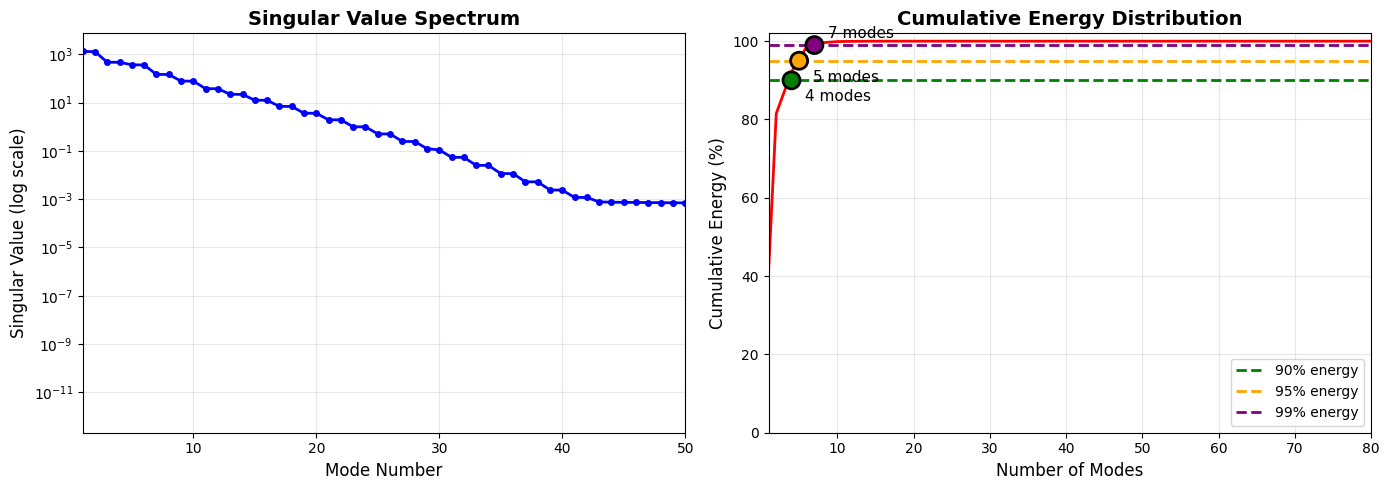


INSIGHT: Energy Distribution
  → 4 modes capture 90% of flow energy
  → 5 modes capture 95% of flow energy
  → 7 modes capture 99% of flow energy

  INTERPRETATION:
  The rapid decay of singular values indicates that bubble
  dynamics are dominated by a few coherent structures.
  This is typical of flows with organized patterns.


In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Singular value spectrum
axes[0].semilogy(range(1, len(pod.singular_values)+1), pod.singular_values, 'b-o', lw=2, markersize=4)
axes[0].set_xlabel('Mode Number', fontsize=12)
axes[0].set_ylabel('Singular Value (log scale)', fontsize=12)
axes[0].set_title('Singular Value Spectrum', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([1, min(50, len(pod.singular_values))])

# Cumulative energy
axes[1].plot(range(1, len(pod.cumulative_energy)+1), pod.cumulative_energy*100, 'r-', lw=2)
axes[1].axhline(y=90, color='g', ls='--', lw=2, label='90% energy')
axes[1].axhline(y=95, color='orange', ls='--', lw=2, label='95% energy')
axes[1].axhline(y=99, color='purple', ls='--', lw=2, label='99% energy')

n_90 = np.searchsorted(pod.cumulative_energy, 0.90) + 1
n_95 = np.searchsorted(pod.cumulative_energy, 0.95) + 1
n_99 = np.searchsorted(pod.cumulative_energy, 0.99) + 1

axes[1].scatter([n_90, n_95, n_99], [90, 95, 99], s=150, zorder=5,
                c=['green', 'orange', 'purple'], edgecolors='black', linewidths=2)
axes[1].annotate(f'{n_90} modes', (n_90, 90), textcoords="offset points", xytext=(10, -15), fontsize=11)
axes[1].annotate(f'{n_95} modes', (n_95, 95), textcoords="offset points", xytext=(10, -15), fontsize=11)
axes[1].annotate(f'{n_99} modes', (n_99, 99), textcoords="offset points", xytext=(10, 5), fontsize=11)

axes[1].set_xlabel('Number of Modes', fontsize=12)
axes[1].set_ylabel('Cumulative Energy (%)', fontsize=12)
axes[1].set_title('Cumulative Energy Distribution', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([1, min(80, len(pod.cumulative_energy))])
axes[1].set_ylim([0, 102])

plt.tight_layout()
plt.show()

print(f'\n{"="*60}')
print('INSIGHT: Energy Distribution')
print(f'{"="*60}')
print(f'  → {n_90} modes capture 90% of flow energy')
print(f'  → {n_95} modes capture 95% of flow energy')
print(f'  → {n_99} modes capture 99% of flow energy')
print(f'\n  INTERPRETATION:')
print(f'  The rapid decay of singular values indicates that bubble')
print(f'  dynamics are dominated by a few coherent structures.')
print(f'  This is typical of flows with organized patterns.')

### 5.2 POD Spatial Modes (Coherent Structures)

Each POD mode represents a **spatial pattern** that captures specific flow physics:

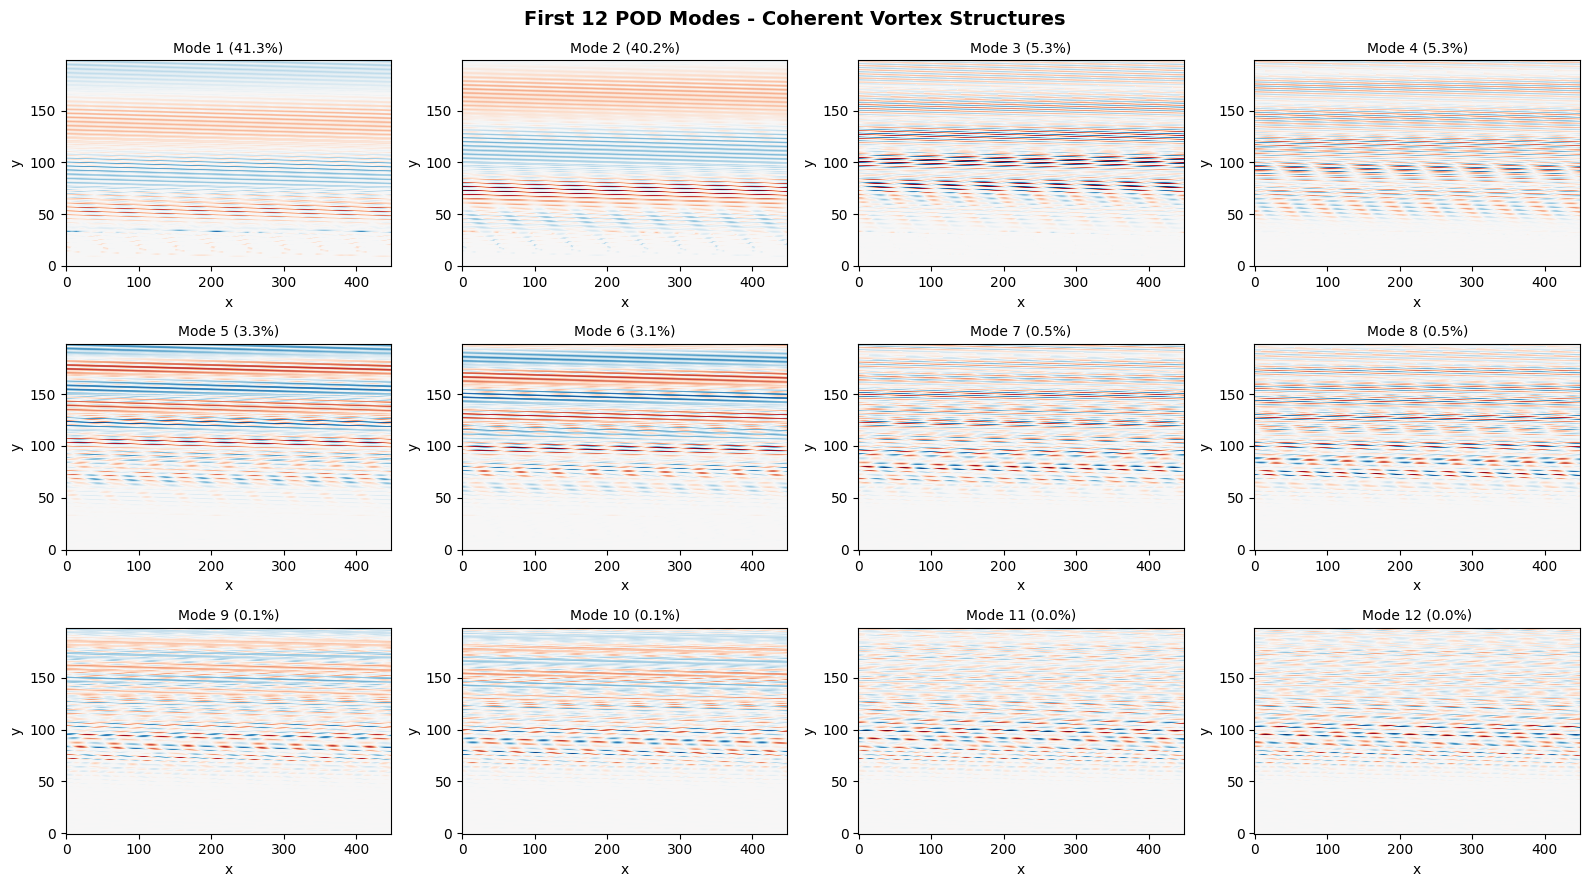


INSIGHT: Physical Interpretation of POD Modes

  Mode 1-2: PRIMARY VORTEX SHEDDING PAIR
          → Appear 90 degrees out of phase
          → Together form the traveling vortex street
          → Capture most of the flow energy

  Modes 3-4: HARMONICS
          → Higher frequency content of vortex shedding
          → Capture non-sinusoidal features

  Higher modes: SMALL-SCALE STRUCTURES
          → Wake turbulence and fine details



In [21]:
fig, axes = plt.subplots(3, 4, figsize=(16, 9))
fig.suptitle('First 12 POD Modes - Coherent Vortex Structures', fontsize=14, fontweight='bold')

for i, ax in enumerate(axes.flat):
    mode_image = pod.modes[:, i].reshape((ny, nx), order='C')
    vmax = np.abs(mode_image).max()
    im = ax.imshow(mode_image, cmap='RdBu_r', origin='lower',
                   aspect='auto', vmin=-vmax, vmax=vmax)
    ax.set_title(f'Mode {i+1} ({pod.energy_per_mode[i]*100:.1f}%)', fontsize=10)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

plt.tight_layout()
plt.show()

print(f'\n{"="*60}')
print('INSIGHT: Physical Interpretation of POD Modes')
print(f'{"="*60}')
print('''
  Mode 1-2: PRIMARY VORTEX SHEDDING PAIR
          → Appear 90 degrees out of phase
          → Together form the traveling vortex street
          → Capture most of the flow energy

  Modes 3-4: HARMONICS
          → Higher frequency content of vortex shedding
          → Capture non-sinusoidal features

  Higher modes: SMALL-SCALE STRUCTURES
          → Wake turbulence and fine details
''')

### 5.3 Mean Flow Field

The mean field represents the **time-averaged vorticity distribution**:

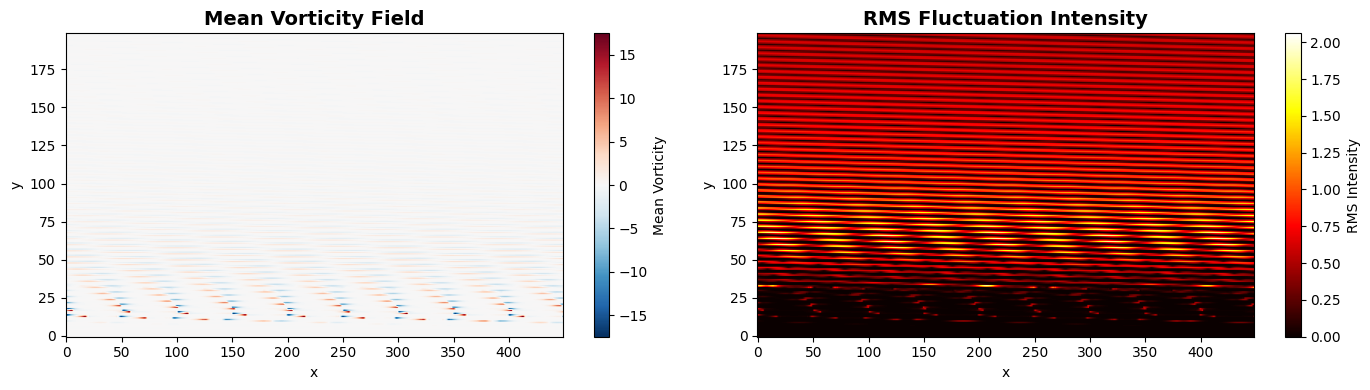


INSIGHT: Mean Field Analysis
  → Mean field shows boundary layer separation
  → High RMS in wake region where vortices pass


In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Mean field
mean_field = pod.mean.reshape((ny, nx), order='C')
vmax = np.abs(mean_field).max()
im1 = axes[0].imshow(mean_field, cmap='RdBu_r', origin='lower',
                     aspect='auto', vmin=-vmax, vmax=vmax)
axes[0].set_title('Mean Vorticity Field', fontsize=14, fontweight='bold')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
plt.colorbar(im1, ax=axes[0], label='Mean Vorticity')

# Fluctuation RMS
fluctuations = X - pod.mean
rms_field = np.std(X, axis=0).reshape((ny, nx), order='C')
im2 = axes[1].imshow(rms_field, cmap='hot', origin='lower', aspect='auto')
axes[1].set_title('RMS Fluctuation Intensity', fontsize=14, fontweight='bold')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
plt.colorbar(im2, ax=axes[1], label='RMS Intensity')

plt.tight_layout()
plt.show()

print(f'\n{"="*60}')
print('INSIGHT: Mean Field Analysis')
print(f'{"="*60}')
print(f'  → Mean field shows boundary layer separation')
print(f'  → High RMS in wake region where vortices pass')

### 5.4 Flow Field Reconstruction with Different Modes

Demonstrating how POD enables **data compression** while preserving flow physics:

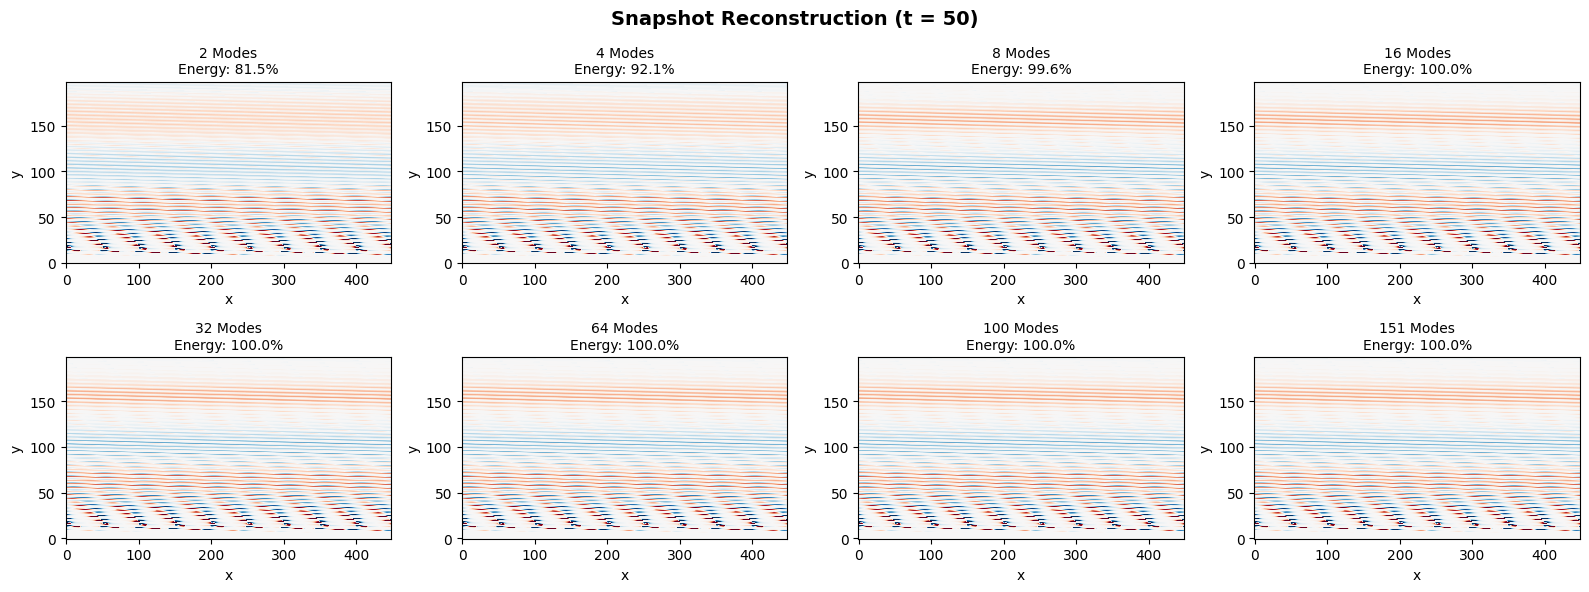


INSIGHT: Reconstruction Quality
  → Just 2 modes capture the main vortex shedding pattern
  → 4-8 modes add harmonic details
  → Higher modes capture fine wake structures


In [23]:
# Select a snapshot
sample_idx = 50
original = VORTALL[:, sample_idx].reshape((ny, nx), order='C')

mode_counts = [2, 4, 8, 16, 32, 64, 100, n_modes_total]
mode_counts = [m for m in mode_counts if m <= n_modes_total]

fig, axes = plt.subplots(2, 4, figsize=(16, 6))
fig.suptitle(f'Snapshot Reconstruction (t = {sample_idx})', fontsize=14, fontweight='bold')

vmax = np.percentile(np.abs(original), 99)

for ax, n in zip(axes.flat, mode_counts):
    rec = pod.reconstruct(n_modes=n)[sample_idx].reshape((ny, nx), order='C')
    energy = pod.cumulative_energy[n-1] * 100
    
    ax.imshow(rec, cmap='RdBu_r', origin='lower', aspect='auto', vmin=-vmax, vmax=vmax)
    ax.set_title(f'{n} Modes\nEnergy: {energy:.1f}%', fontsize=10)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

plt.tight_layout()
plt.show()

print(f'\n{"="*60}')
print('INSIGHT: Reconstruction Quality')
print(f'{"="*60}')
print(f'  → Just 2 modes capture the main vortex shedding pattern')
print(f'  → 4-8 modes add harmonic details')
print(f'  → Higher modes capture fine wake structures')

### 5.5 Temporal Dynamics of POD Modes

The **temporal coefficients** reveal how each mode evolves in time:

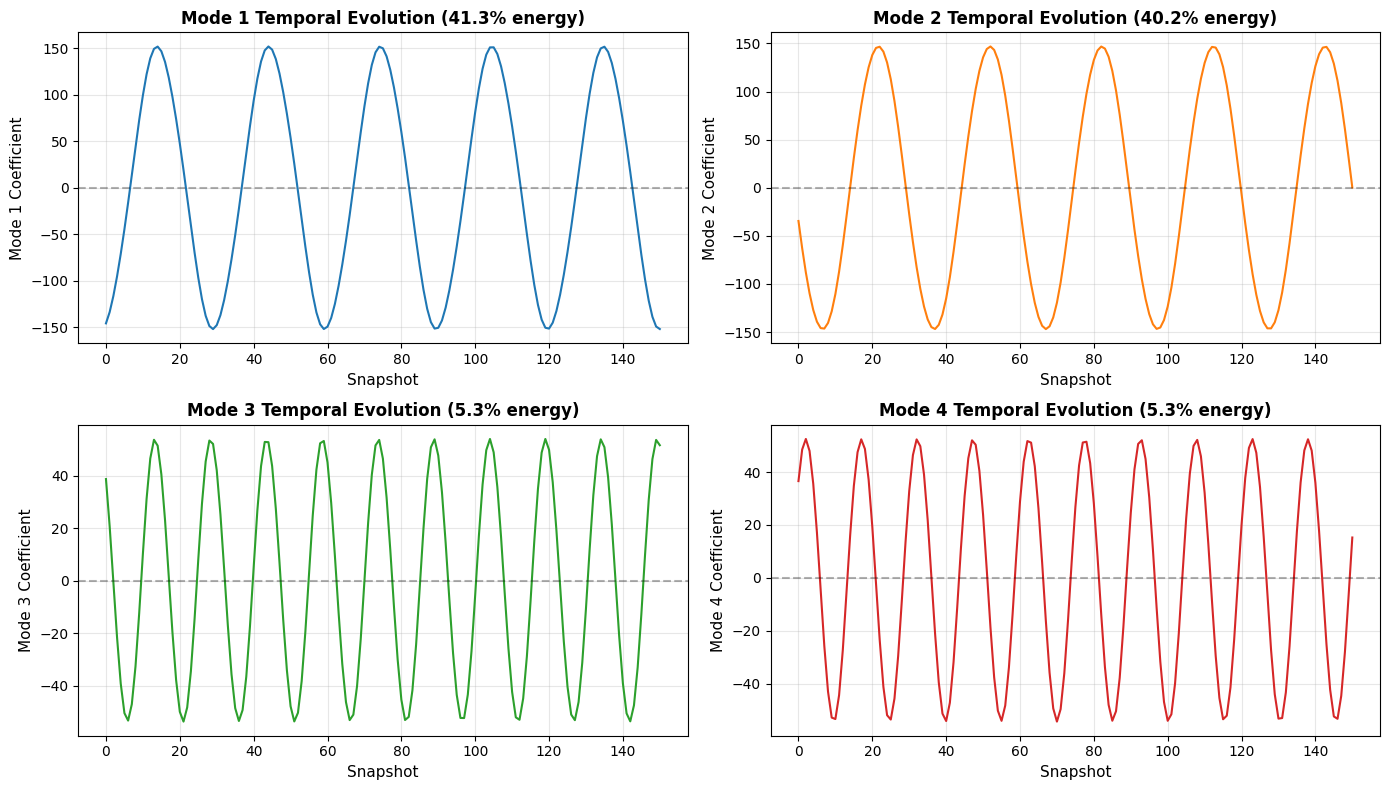


INSIGHT: Temporal Dynamics

  Modes 1 & 2: SINUSOIDAL and ~90 deg out of phase
             → Together form a TRAVELING WAVE (vortex street)

  Higher modes: Show harmonic content
             → Capture non-sinusoidal features



In [24]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

for i, ax in enumerate(axes.flat):
    ax.plot(time, pod.temporal_coeffs[:, i], lw=1.5, color=f'C{i}')
    ax.set_xlabel('Snapshot', fontsize=11)
    ax.set_ylabel(f'Mode {i+1} Coefficient', fontsize=11)
    ax.set_title(f'Mode {i+1} Temporal Evolution ({pod.energy_per_mode[i]*100:.1f}% energy)',
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', ls='--', alpha=0.3)

plt.tight_layout()
plt.show()

print(f'\n{"="*60}')
print('INSIGHT: Temporal Dynamics')
print(f'{"="*60}')
print('''
  Modes 1 & 2: SINUSOIDAL and ~90 deg out of phase
             → Together form a TRAVELING WAVE (vortex street)

  Higher modes: Show harmonic content
             → Capture non-sinusoidal features
''')


### 5.6 Reconstruction Error Analysis

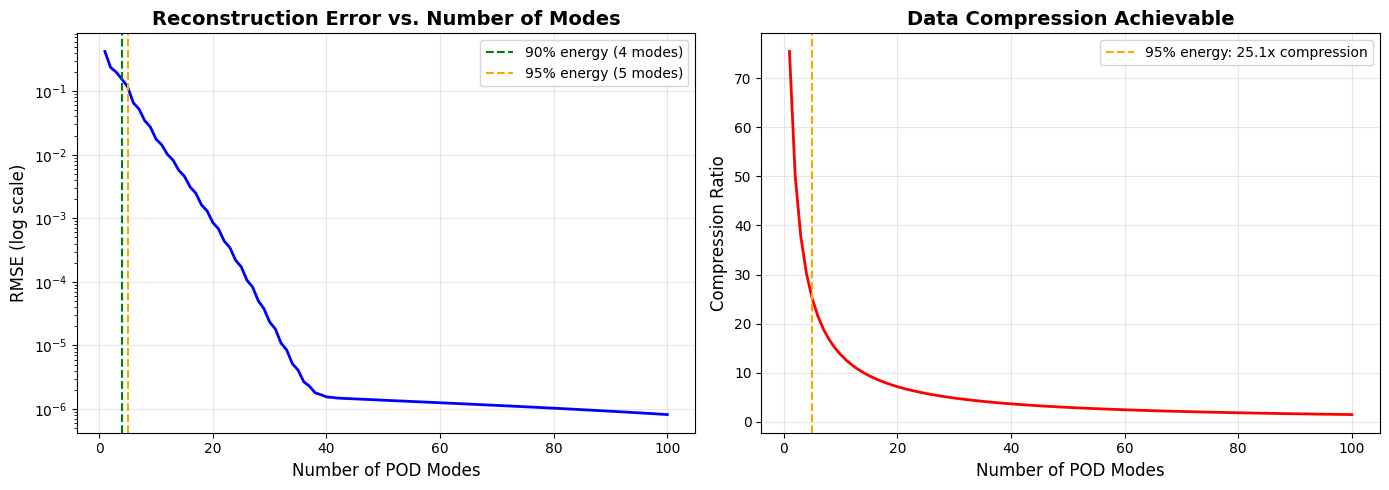


INSIGHT: Compression Analysis
  → Original data: 151 snapshots × 89351 points = 13,492,001 values
  → With 5 modes: ~25.1x compression


In [25]:
# Compute reconstruction error vs number of modes
n_modes_range = range(1, min(100, n_modes_total) + 1)
rmse_values = []

for nm in n_modes_range:
    X_reconstructed = pod.reconstruct(n_modes=nm)
    rmse = np.sqrt(np.mean((X - X_reconstructed)**2))
    rmse_values.append(rmse)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE vs modes
axes[0].semilogy(n_modes_range, rmse_values, 'b-', lw=2)
axes[0].set_xlabel('Number of POD Modes', fontsize=12)
axes[0].set_ylabel('RMSE (log scale)', fontsize=12)
axes[0].set_title('Reconstruction Error vs. Number of Modes', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=n_90, color='g', ls='--', label=f'90% energy ({n_90} modes)')
axes[0].axvline(x=n_95, color='orange', ls='--', label=f'95% energy ({n_95} modes)')
axes[0].legend()

# Compression ratio
compression = [(X.shape[0] * X.shape[1]) / (X.shape[0] * nm + nm * X.shape[1] + X.shape[1])
               for nm in n_modes_range]
axes[1].plot(n_modes_range, compression, 'r-', lw=2)
axes[1].set_xlabel('Number of POD Modes', fontsize=12)
axes[1].set_ylabel('Compression Ratio', fontsize=12)
axes[1].set_title('Data Compression Achievable', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=n_95, color='orange', ls='--', label=f'95% energy: {compression[n_95-1]:.1f}x compression')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f'\n{"="*60}')
print('INSIGHT: Compression Analysis')
print(f'{"="*60}')
print(f'  → Original data: {X.shape[0]} snapshots × {X.shape[1]} points = {X.shape[0]*X.shape[1]:,} values')
print(f'  → With {n_95} modes: ~{compression[n_95-1]:.1f}x compression')

### 5.7 Phase Space Analysis

The **phase portrait** reveals the dynamical behavior of the system:

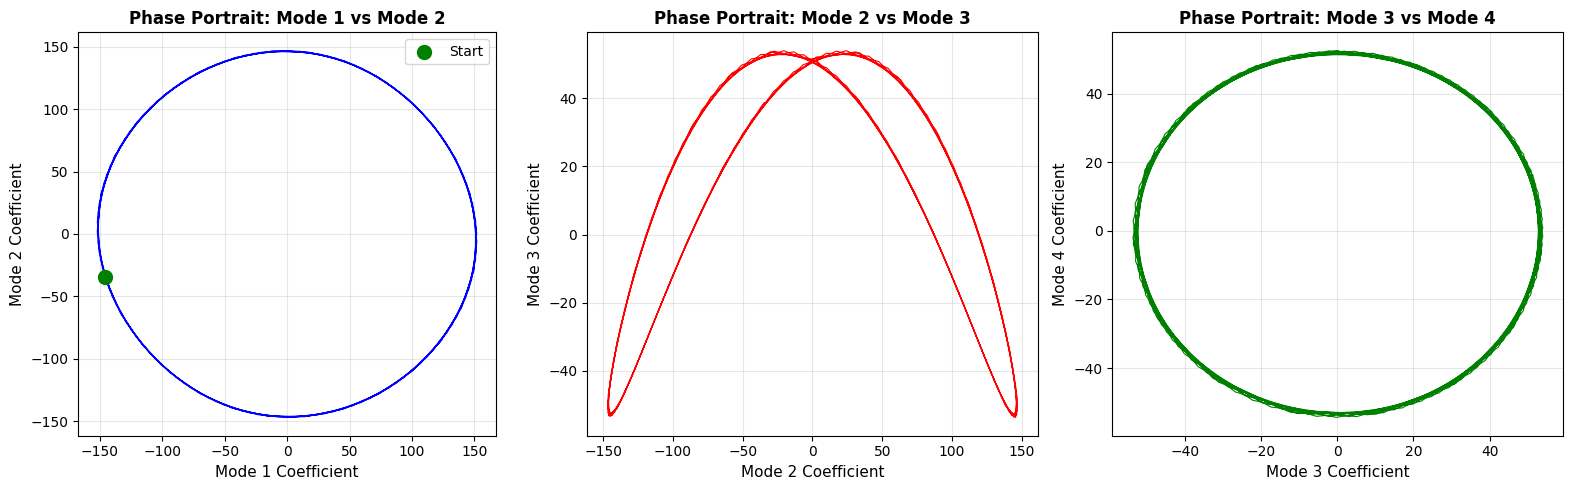


INSIGHT: Phase Space Dynamics

  Mode 1 vs Mode 2 forms a CIRCLE:
    → This indicates a LIMIT CYCLE (periodic attractor)
    → Characteristic of stable vortex shedding



In [26]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Mode 1 vs Mode 2
axes[0].plot(pod.temporal_coeffs[:, 0], pod.temporal_coeffs[:, 1], 'b-', lw=0.8)
axes[0].scatter(pod.temporal_coeffs[0, 0], pod.temporal_coeffs[0, 1], c='green', s=100, zorder=5, label='Start')
axes[0].set_xlabel('Mode 1 Coefficient', fontsize=11)
axes[0].set_ylabel('Mode 2 Coefficient', fontsize=11)
axes[0].set_title('Phase Portrait: Mode 1 vs Mode 2', fontsize=12, fontweight='bold')
axes[0].set_aspect('equal')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Mode 2 vs Mode 3
axes[1].plot(pod.temporal_coeffs[:, 1], pod.temporal_coeffs[:, 2], 'r-', lw=0.8)
axes[1].set_xlabel('Mode 2 Coefficient', fontsize=11)
axes[1].set_ylabel('Mode 3 Coefficient', fontsize=11)
axes[1].set_title('Phase Portrait: Mode 2 vs Mode 3', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Mode 3 vs Mode 4
axes[2].plot(pod.temporal_coeffs[:, 2], pod.temporal_coeffs[:, 3], 'g-', lw=0.8)
axes[2].set_xlabel('Mode 3 Coefficient', fontsize=11)
axes[2].set_ylabel('Mode 4 Coefficient', fontsize=11)
axes[2].set_title('Phase Portrait: Mode 3 vs Mode 4', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'\n{"="*60}')
print('INSIGHT: Phase Space Dynamics')
print(f'{"="*60}')
print('''
  Mode 1 vs Mode 2 forms a CIRCLE:
    → This indicates a LIMIT CYCLE (periodic attractor)
    → Characteristic of stable vortex shedding
''')


### 5.8 Frequency Content Analysis

Spectral analysis reveals the **dominant frequencies** in the flow:

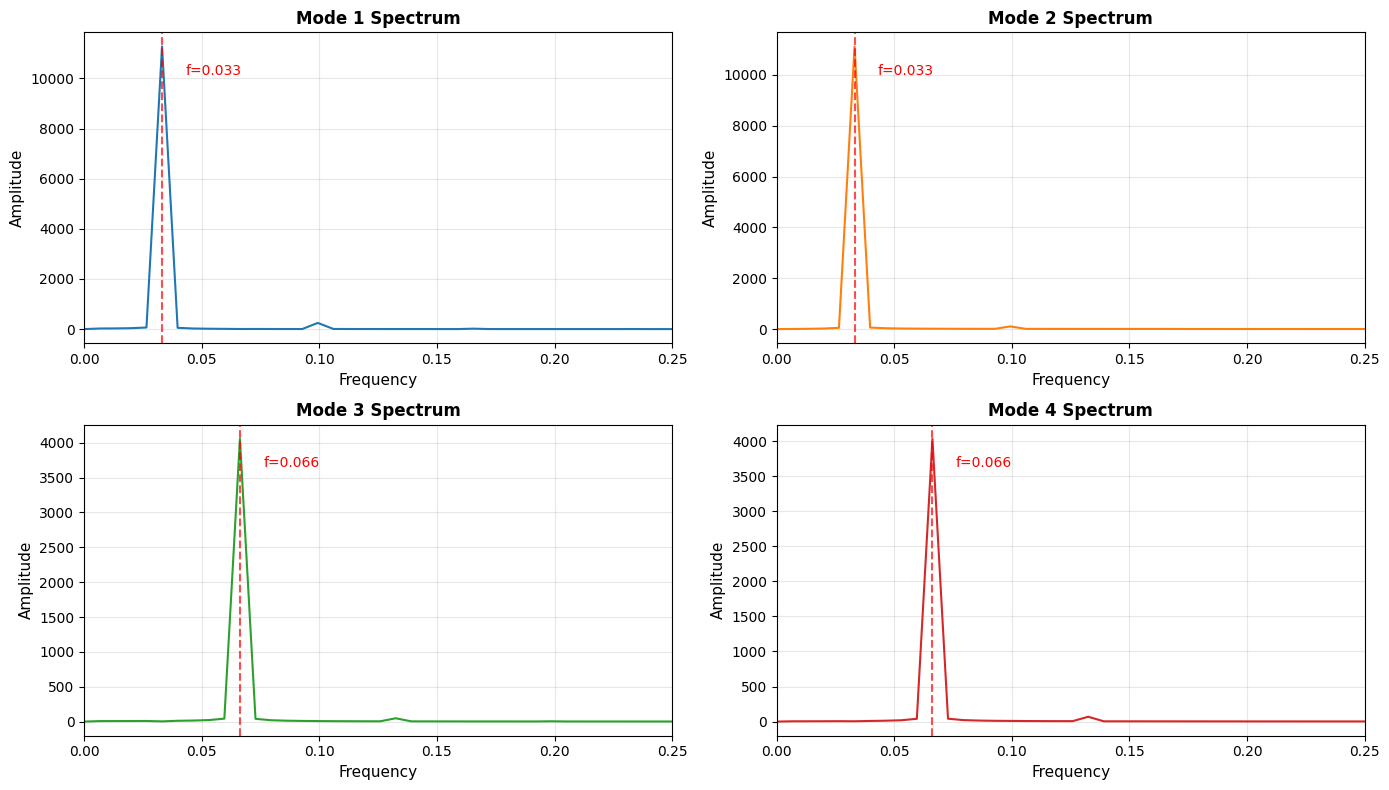

INSIGHT: Dominant frequency is the Strouhal shedding frequency


In [27]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

freq = fftfreq(n_snapshots, d=1.0)[:n_snapshots//2]

for i, ax in enumerate(axes.flat):
    spectrum = np.abs(fft(pod.temporal_coeffs[:, i]))[:n_snapshots//2]
    spectrum[0] = 0  # Remove DC

    ax.plot(freq, spectrum, lw=1.5, color=f'C{i}')
    ax.set_xlabel('Frequency', fontsize=11)
    ax.set_ylabel('Amplitude', fontsize=11)
    ax.set_title(f'Mode {i+1} Spectrum', fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 0.25])

    # Mark peak
    peak_idx = np.argmax(spectrum)
    if peak_idx > 0:
        ax.axvline(freq[peak_idx], color='r', ls='--', alpha=0.7)
        ax.text(freq[peak_idx]+0.01, spectrum[peak_idx]*0.9, f'f={freq[peak_idx]:.3f}', color='r')

plt.tight_layout()
plt.show()

print('INSIGHT: Dominant frequency is the Strouhal shedding frequency')


### 5.9 Mode Comparison: Original vs Individual Mode Contributions

Visualizing how each mode contributes to the flow field:

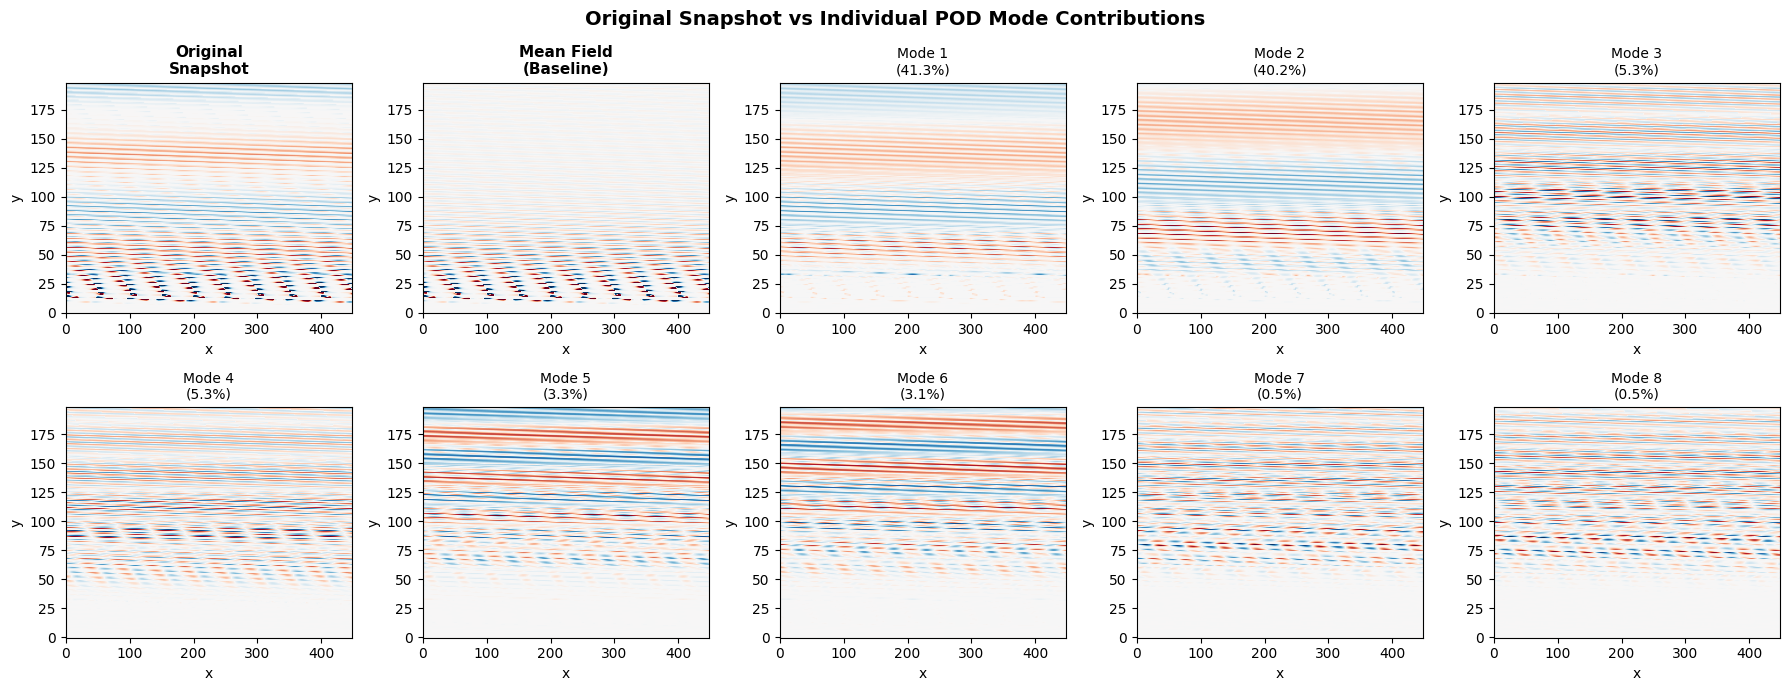

Each mode shows its weighted contribution to the snapshot
Sum of mean + all modes = original snapshot


In [28]:
fig, axes = plt.subplots(2, 5, figsize=(18, 7))
fig.suptitle('Original Snapshot vs Individual POD Mode Contributions', fontsize=14, fontweight='bold')

# Original snapshot
snapshot_idx = 75
original = VORTALL[:, snapshot_idx].reshape((ny, nx), order='C')
vmax_orig = np.percentile(np.abs(original), 99)

axes[0, 0].imshow(original, cmap='RdBu_r', origin='lower', aspect='auto', vmin=-vmax_orig, vmax=vmax_orig)
axes[0, 0].set_title('Original\nSnapshot', fontsize=11, fontweight='bold')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('y')

# Mean field
mean_img = pod.mean.reshape((ny, nx), order='C')
axes[0, 1].imshow(mean_img, cmap='RdBu_r', origin='lower', aspect='auto', vmin=-vmax_orig, vmax=vmax_orig)
axes[0, 1].set_title('Mean Field\n(Baseline)', fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('y')

# Individual mode contributions
for i in range(8):
    row = (i + 2) // 5
    col = (i + 2) % 5

    # Mode contribution = temporal_coeff * mode
    mode_contribution = pod.temporal_coeffs[snapshot_idx, i] * pod.modes[:, i]
    mode_img = mode_contribution.reshape((ny, nx), order='C')
    vmax_mode = np.abs(mode_img).max()

    axes[row, col].imshow(mode_img, cmap='RdBu_r', origin='lower', aspect='auto', vmin=-vmax_mode, vmax=vmax_mode)
    axes[row, col].set_title(f'Mode {i+1}\n({pod.energy_per_mode[i]*100:.1f}%)', fontsize=10)
    axes[row, col].set_xlabel('x')
    axes[row, col].set_ylabel('y')

plt.tight_layout()
plt.show()

print('Each mode shows its weighted contribution to the snapshot')
print('Sum of mean + all modes = original snapshot')


## 6. Summary & Key Findings

In [29]:
print('='*70)
print('     POD ANALYSIS OF VON KARMAN VORTEX STREET - SUMMARY')
print('='*70)

print(f'''
DATASET:
  Source: Real CFD simulation (Brunton & Kutz textbook)
  Physics: Cylinder wake, Re ~ 100
  Grid: {ny} x {nx} = {ny*nx:,} points
  Snapshots: {n_snapshots}

RESULTS:
  Mode 1 energy: {pod.energy_per_mode[0]*100:.1f}%
  Mode 2 energy: {pod.energy_per_mode[1]*100:.1f}%
  Modes 1+2: {pod.cumulative_energy[1]*100:.1f}% (vortex shedding)

  90% energy: {n_90} modes
  95% energy: {n_95} modes
  99% energy: {n_99} modes

KEY INSIGHTS:
  1. Vortex shedding is LOW-DIMENSIONAL (2 modes dominate)
  2. Modes 1 & 2 are 90 deg out of phase = traveling wave
  3. Phase portrait shows LIMIT CYCLE = periodic dynamics
  4. Clear Strouhal frequency in spectrum
''')
print('='*70)

     POD ANALYSIS OF VON KARMAN VORTEX STREET - SUMMARY

DATASET:
  Source: Real CFD simulation (Brunton & Kutz textbook)
  Physics: Cylinder wake, Re ~ 100
  Grid: 199 x 449 = 89,351 points
  Snapshots: 151

RESULTS:
  Mode 1 energy: 41.3%
  Mode 2 energy: 40.2%
  Modes 1+2: 81.5% (vortex shedding)

  90% energy: 4 modes
  95% energy: 5 modes
  99% energy: 7 modes

KEY INSIGHTS:
  1. Vortex shedding is LOW-DIMENSIONAL (2 modes dominate)
  2. Modes 1 & 2 are 90 deg out of phase = traveling wave
  3. Phase portrait shows LIMIT CYCLE = periodic dynamics
  4. Clear Strouhal frequency in spectrum



## 7. Conclusions & Applications

### Key Findings

1. **Low-Dimensional Nature of Vortex Shedding**
   - Despite the complex appearance, the flow is governed by just 2 dominant modes
   - This is characteristic of periodic flows with organized coherent structures

2. **Physical Interpretation of POD Modes**
   - **Modes 1-2**: Primary vortex shedding pair (90° phase shift = traveling wave)
   - **Modes 3-4**: Harmonics of the shedding frequency
   - **Higher modes**: Fine-scale wake structures

3. **Practical Benefits of POD**
   - **Data Compression**: Significant reduction in storage
   - **Reduced-Order Modeling**: Can build predictive models with few modes
   - **Flow Control**: Design controllers based on dominant modes

### References

- Brunton & Kutz (2019) *Data-Driven Science and Engineering* - Dataset source
- Lumley (1967) "The structure of inhomogeneous turbulent flows"
- Sirovich (1987) "Turbulence and the dynamics of coherent structures"
